In [29]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# @Author: Mingyeong Yang (mmingyeong@kasi.re.kr)
# @Date: 2023-12-12
# @Filename: final_report.ipynb
# work.

import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import math

import pandas as pd

In [30]:
# Data Preparation
# Pantheon: SN Ia Pantheon data

file_lcparam_full_long = "./Pantheon/lcparam_full_long.txt"
file_sys_full_long = "./Pantheon/sys_full_long.txt"

open_lcparam_full_long = open(file_lcparam_full_long, "r")
open_sys_full_long = open(file_sys_full_long, "r")

df_lcparam_full_long = pd.read_csv(file_lcparam_full_long, sep = ' ')
df_sys_full_long = pd.DataFrame(open_sys_full_long)

In [31]:
# zcmb, mb 추출
df_lcparam_full_long = df_lcparam_full_long.iloc[:,[1,4]]
df_sys_full_long[0] = df_sys_full_long[0].str.replace(pat=r'\n', repl=r'', regex=True)

In [32]:
import scipy.integrate as spi
import math

# I will consider only flat cosmological model
#
# flat L CDM w=-1
# flat w CDM  wo -> varias, wa = 0
# w = wo + wa*z/(1+z)

def DL_func(z_list, H0, w, Omega_M):
    Omega_L = 1-Omega_M
    res_list = []
    for z in z_list:
        def h_func(z):
            h = np.sqrt(Omega_M*(1+z)**3 + Omega_L*(1+z)**(3*(1+w)))
            return 1/h
        c = 299792 # km/sec
        qd_val, qd_err = spi.quad(h_func, 0, z)
        res = c*(1+z)*qd_val/H0
        res_list.append(res)
    return res_list

def DL_data(mb):
    # return value = distance
    # mu = mb - MB = 5*log(dL) -> unit: 10 PC
    # mu = mb + other errors
    # These error is not considered.
    results = []
    MB = 19.3
    for val in mb:
        res = 10**((val-MB)/5)
        results.append(res)

    return results


In [33]:
mb = list(df_lcparam_full_long["mb"])
z = list(df_lcparam_full_long["zcmb"])
DL = DL_data(mb)

In [34]:

def chi_squared_cov(y, model, cov):
    dm = []
    for i in range(len(y)):
        term1 = y[i]-model[i]
        dm.append(term1)
        
    dm_arr = np.array(dm)
    dm_transpose = dm_arr.T # transpose matrix of y
    # inverse of covariance matrix
    reg_param = 1e-3
    inv_cov = np.linalg.inv(cov + reg_param * np.eye(cov.shape[0]))
    #inv_cov = np.linalg.pinv(cov)
    term2 = np.dot(dm_transpose, inv_cov)
    chis_val = np.dot(term2, dm_arr)

    return chis_val

In [35]:
cov_ex = np.array(df_sys_full_long[0][1:1049])
cov = []
n=1
while True:
    cov_comp = list(map(float, df_sys_full_long[0][n:n+1048]))
    cov.append(cov_comp)
    n=n+1048
    #print(n)
    if n >1098305:
        break

cov.pop()
cov_arr = np.array(cov)

In [36]:
H0_old = 70
Om0_old = 0.3
w_old = -1
old_pos = [H0_old, Om0_old, w_old]

chis = chi_squared_cov(DL, DL_func(z, *old_pos), cov_arr) / 10**12  # 10**12로 nomalize
old_likelihood = new_likelihood = np.exp(-chis**2/2)

In [37]:
print(chis)
print(old_likelihood)

1.7746412836893193
0.20707466652887763


In [38]:
import random

# H0_old, Om0_old
# # make new positions
record = []
new_position_list = []
new_pos = []
new_likelihood_list = []
chis = []
for i in range(1000):
    H0_new, Om0_new, w_new = H0_old + np.random.normal(0, 0.1), Om0_old+ np.random.normal(0, 0.1), w_old + np.random.normal(0, 0.1)
    # step size
    new_pos = [H0_new, Om0_new, w_new]
    
    # Calculate the likelihood
    chi_val = chi_squared_cov(DL, DL_func(z, *new_pos), cov_arr)/ 10**12  # 10**12로 nomalize
    #print(chi_val)
    new_likelihood = np.exp(-chi_val**2/2) 

    if new_likelihood > old_likelihood:
        new_position_list.append(new_pos)
        new_likelihood_list.append(new_likelihood)
        old_pos = new_pos
    elif new_likelihood < old_likelihood:
        rd = random.random()
        if rd < new_likelihood/old_likelihood:
            record.append(new_pos)
            new_position_list.append(new_pos)
            new_likelihood_list.append(new_likelihood)
            old_pos = new_pos
        else:
            record.append(old_pos)
            new_position_list.append(old_pos)
            new_likelihood_list.append(old_likelihood)
            old_pos = old_pos


In [39]:
minimum_chi = min(new_likelihood_list)
index = new_likelihood_list.index(minimum_chi)
print(new_likelihood_list[index])

0.061776126167401774


In [40]:
a_list = []
b_list = []
c_list = []
for i in range(len(new_position_list)):
    new_pos = new_position_list[i]
    a_list.append(new_pos[0])
    b_list.append(new_pos[1])
    c_list.append(new_pos[2])

peak_a = new_position_list[index][0]
peak_b = new_position_list[index][1]
peak_c = new_position_list[index][2]

peak_a = round(peak_a,2)
peak_b = round(peak_b,2)
peak_c = round(peak_c,2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


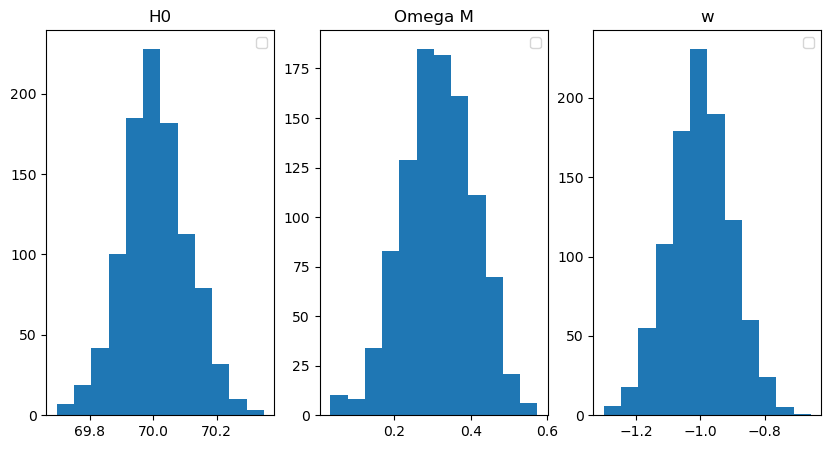

In [41]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.hist(a_list, bins=12)
#plt.vlines(peak_a, ymin=0, ymax=200, colors="r", label=f"best fit value {peak_a}")
plt.title('H0')
plt.legend()

plt.subplot(1,3,2)
plt.hist(b_list, bins=12)
#plt.vlines(peak_b, ymin=0, ymax=200, colors="r", label=f"best fit value {peak_b}")
plt.title('Omega M')
plt.legend()

plt.subplot(1,3,3)
plt.hist(c_list, bins=12)
#plt.vlines(peak_c, ymin=0, ymax=200, colors="r", label=f"best fit value {peak_c}")
plt.title('w')
plt.legend()
plt.show()

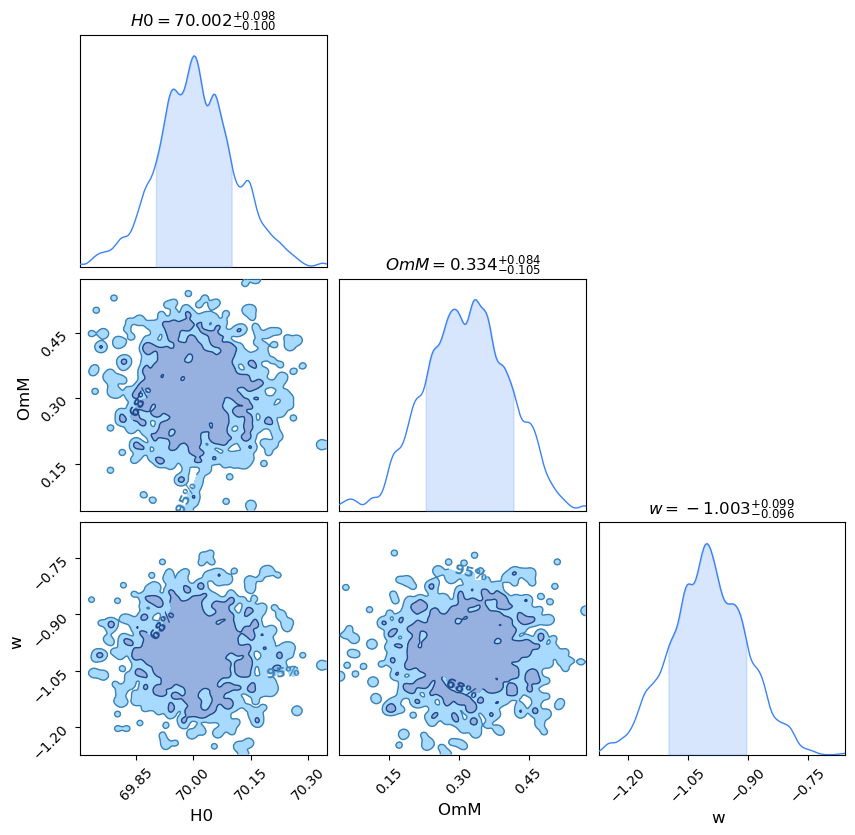

In [42]:
from chainconsumer import Chain, ChainConsumer, make_sample, PlotConfig

df = pd.DataFrame({"H0":a_list, "OmM":b_list, "w":c_list})
c = ChainConsumer()
c.add_chain(Chain(
    samples=df, 
    name="Pantheon SNla", 
    show_contour_labels=True,))
fig = c.plotter.plot()